# Sensitivity analysis </a><a name='top'>

In this notebook we try to study the sensivity of our model to critical parameters.

[Define general default parameters for the whole of the analysis](#default)

[Define the 5 fields that change for each parameter tested](#testing)
    
    
**WARNING: FOR SECURITY OF DATA, SET save_figures TO FALSE AFTER EACH USE AND CHANGE NAME OF directory_to_save_figs_in (OTHERWISE FIGURES THAT WERE PREVIOUSLY SAVED MIGHT BE LOST BY REPLACEMENT).**

In [2]:
# TODO: TODOs hehe, correct model, new metrics, parallelize (?), data-processing params (window size median filters, size of subset saved to .nc > computation time)
# TODO are parameters independent? i.e. is the one at a time approach relevant?
# TODO should the tests be carried out on several geographical points?

## Imports and functions

In [1]:
%run little_awk_functions.py

In [2]:
def squared_diff(ds, x_sel, y_sel, dt, nb_iterations, total_snow_depth):
    '''
    Function that computes the sum of squared differences between points on the lidar curve and corresponding
    simulation points
    Args:
        ds: clean dataset
        x_sel: x-coordinate of the point of interest (index)
        y_sel: y-coordinate of the point of interest (index)
        dt: timestep of simulation (s)
        nb_iterations: number of iterations in the simulation
        total_snow_depth: array containing the simulated total snow depth (1 point per iteration)
    Returns:
        sq_sum: sum of the squared differences between points in ds and points in total_snow_depth
    '''
    sq_sum = 0
    for index in range(len(ds.time.values)):
        lidar_time_in_s = float(ds.time.values[index]) / 1000000000 - float(ds.time.values[0]) / 1000000000
        if lidar_time_in_s < nb_iterations*dt:
            index_of_closest_time_in_simul = int(lidar_time_in_s//dt + round((lidar_time_in_s%dt)/dt))
            difference_curve_lidar = ds.snow_surface.isel(x=x_sel, y=y_sel, time=index) - total_snow_depth[index_of_closest_time_in_simul]
            sq_sum += float(difference_curve_lidar**2)
        else:
            return(sq_sum)
    return(sq_sum)

In [3]:
def abs_diff(ds, x_sel, y_sel, dt, nb_iterations, total_snow_depth):
    '''
    Function that computes the sum of differences in absolute value between points on the lidar curve and corresponding
    simulation points
    Args:
        ds: clean dataset
        x_sel: x-coordinate of the point of interest (index)
        y_sel: y-coordinate of the point of interest (index)
        dt: timestep of simulation (s)
        nb_iterations: number of iterations in the simulation
        total_snow_depth: array containing the simulated total snow depth (1 point per iteration)
    Returns:
        abs_sum: sum of the differences in absolute value between points in ds and points in total_snow_depth
    '''
    abs_sum = 0
    for index in range(len(ds.time.values)):
        lidar_time_in_s = float(ds.time.values[index]) / 1000000000 - float(ds.time.values[0]) / 1000000000
        if lidar_time_in_s < nb_iterations*dt:
            index_of_closest_time_in_simul = int(lidar_time_in_s//dt + round((lidar_time_in_s%dt)/dt))
            difference_curve_lidar = ds.snow_surface.isel(x=x_sel, y=y_sel, time=index) - total_snow_depth[index_of_closest_time_in_simul]
            abs_sum += float(abs(difference_curve_lidar))
        else:
            return(abs_sum)
    return(abs_sum)

In [4]:
def max_abs_diff(ds, x_sel, y_sel, dt, nb_iterations, total_snow_depth):
    '''
    Function that computes the maximun of differences in absolute value between points on the lidar curve and corresponding
    simulation points
    Args:
        ds: clean dataset
        x_sel: x-coordinate of the point of interest (index)
        y_sel: y-coordinate of the point of interest (index)
        dt: timestep of simulation (s)
        nb_iterations: number of iterations in the simulation
        total_snow_depth: array containing the simulated total snow depth (1 point per iteration)
    Returns:
        abs_max: maximum of the differences in absolute value between points in ds and points in total_snow_depth
    '''
    abs_max = 0
    for index in range(len(ds.time.values)):
        lidar_time_in_s = float(ds.time.values[index]) / 1000000000 - float(ds.time.values[0]) / 1000000000
        if lidar_time_in_s < nb_iterations*dt:
            index_of_closest_time_in_simul = int(lidar_time_in_s//dt + round((lidar_time_in_s%dt)/dt))
            difference_curve_lidar = float(abs(ds.snow_surface.isel(x=x_sel, y=y_sel, time=index) - total_snow_depth[index_of_closest_time_in_simul]))
            if difference_curve_lidar > abs_max:
                abs_max = difference_curve_lidar
        else:
            return(abs_max)
    return(abs_max)

In [5]:
def area_between_curves(ds, x_sel, y_sel, dt, nb_iterations, total_snow_depth):
    # TODO how to compute this? Turn it into a sum? Will it make a big difference compared to abs_diff?
    # For now we ignore this measure
    return()

## Define default parameters </a><a name='default'>

These should be defined once only at the beginning of the analysis, and not changed during the process.

In [6]:
paramdic = {}

In [7]:
# Dataset

name_of_data_set = 'snow_pit_1_filled.nc'      # TODO partial?
offset = 0.35414986           # TODO deal with this
# data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time= start_accumulation[0]) can be chosen as offset (run a first computation first with offset set to 0)

save_figures = False
save_text_results = False

directory_to_save_figs_in = '/home/mabonnet/github/MB_little_awk/current_development/Sensitivity_tests_figs_2/'

paramdic['data_set_used'] = name_of_data_set
paramdic['offset'] = offset

In [8]:
# Events detection parameters

x_sel = 10
y_sel = 10
time_window_std = 25
std_threshold = 0.015    # TODO choose the correct threshold here

paramdic['x_sel'] = x_sel
paramdic['y_sel'] = y_sel
paramdic['time_window_std'] = time_window_std
paramdic['std_threshold'] = std_threshold

In [9]:
# Compaction/temperature model parameters

tsfc = -5
cp_snow = 2106
dt = 100
a1 = 0.0013
a2 = 0.021

use_true_temp = True   # set to True if want to use the correct temperature forcing

simul_new_snow_ro = 150         # TODO choose the correct value here

# TODO add ice layer detection option > not yet

paramdic['tsfc'] = tsfc
paramdic['cp_snow'] = cp_snow
paramdic['dt'] = dt
paramdic['a1'] = a1
paramdic['a2'] = a2
paramdic['use_true_temp'] = use_true_temp
paramdic['simul_new_snow_ro'] = simul_new_snow_ro

# Will not be varied for now

max_nb_of_layers = 25
simul_fit_top_of_snowfall_to_curve = False
tf = 0
ro_water = 1000
ro_ice = 910
jj = 0

paramdic['stable_parameters'] = 'max nb layers 25; do not fit top of snowfall to curve; tf 0; ro water 1000; ro ice 910; initial nb layers 0'

In [10]:
# Save default parameters in a .txt file

if save_text_results:
    with open(directory_to_save_figs_in + 'sensitivity_tests.txt', 'a') as param_file:
        param_file.write(str(paramdic) + '\n \n')

[Back to top section](#top)

## Clean dataset and derive other parameters

You should only need to run this once.

In [11]:
# Pre-processing to get clean data

data_set_used = xr.open_dataset(name_of_data_set)

if name_of_data_set == 'data_2021-2022.nc':
    fill_in_missing_variables(data_set_used, 'surface')

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7)
if name_of_data_set == 'data_2021-2022.nc':
    median_time_filtering(data_set_used, 11)

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].min() - offset


---> Median filtering in space with a window [7, 11]


In [12]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

data_start_date = pd.to_datetime('2021-12-06T00:00')      # TODO make sure this is the right date > functionalize? can just use data_starting_date_in_s?

In [13]:
# Define structures to store snow parameters

ro_layer = np.zeros((max_nb_of_layers, 1))
t_old = np.zeros((max_nb_of_layers, 1))
dy_snow = np.zeros((max_nb_of_layers, 1))
gamma = np.zeros((max_nb_of_layers, 1))
melt_flag = np.zeros((max_nb_of_layers, 1))

In [14]:
# Meteorological forcing

if use_true_temp:
    met_time, met_temp = get_met_forcing()
else:
    met_time, met_temp = [0], [tsfc]

## Loop on parameter of interest variation </a><a name='testing'>

There are 5 fields to change each time (see TODOs).

In [15]:
# met_temp, met_time = [None], [0]

In [16]:
# Define all the values the parameter of interest will take

name_of_param = 'a2'   # TODO update this each time
default_value_of_param = 0.021   # TODO update this each time
range_of_param_variation = [0.015, 0.018, 0.021, 0.023, 0.025, 0.03]   # TODO update this each time
# Best if range_of_param_variation contains an even number of values (for the figure)

result_list_sq = []            # TODO adapt to chosen metric
result_list_abs = []
result_list_max_abs = []

In [17]:
# TODO optimize each time as a function of offset added to lidar curve? Nope, stay comparable

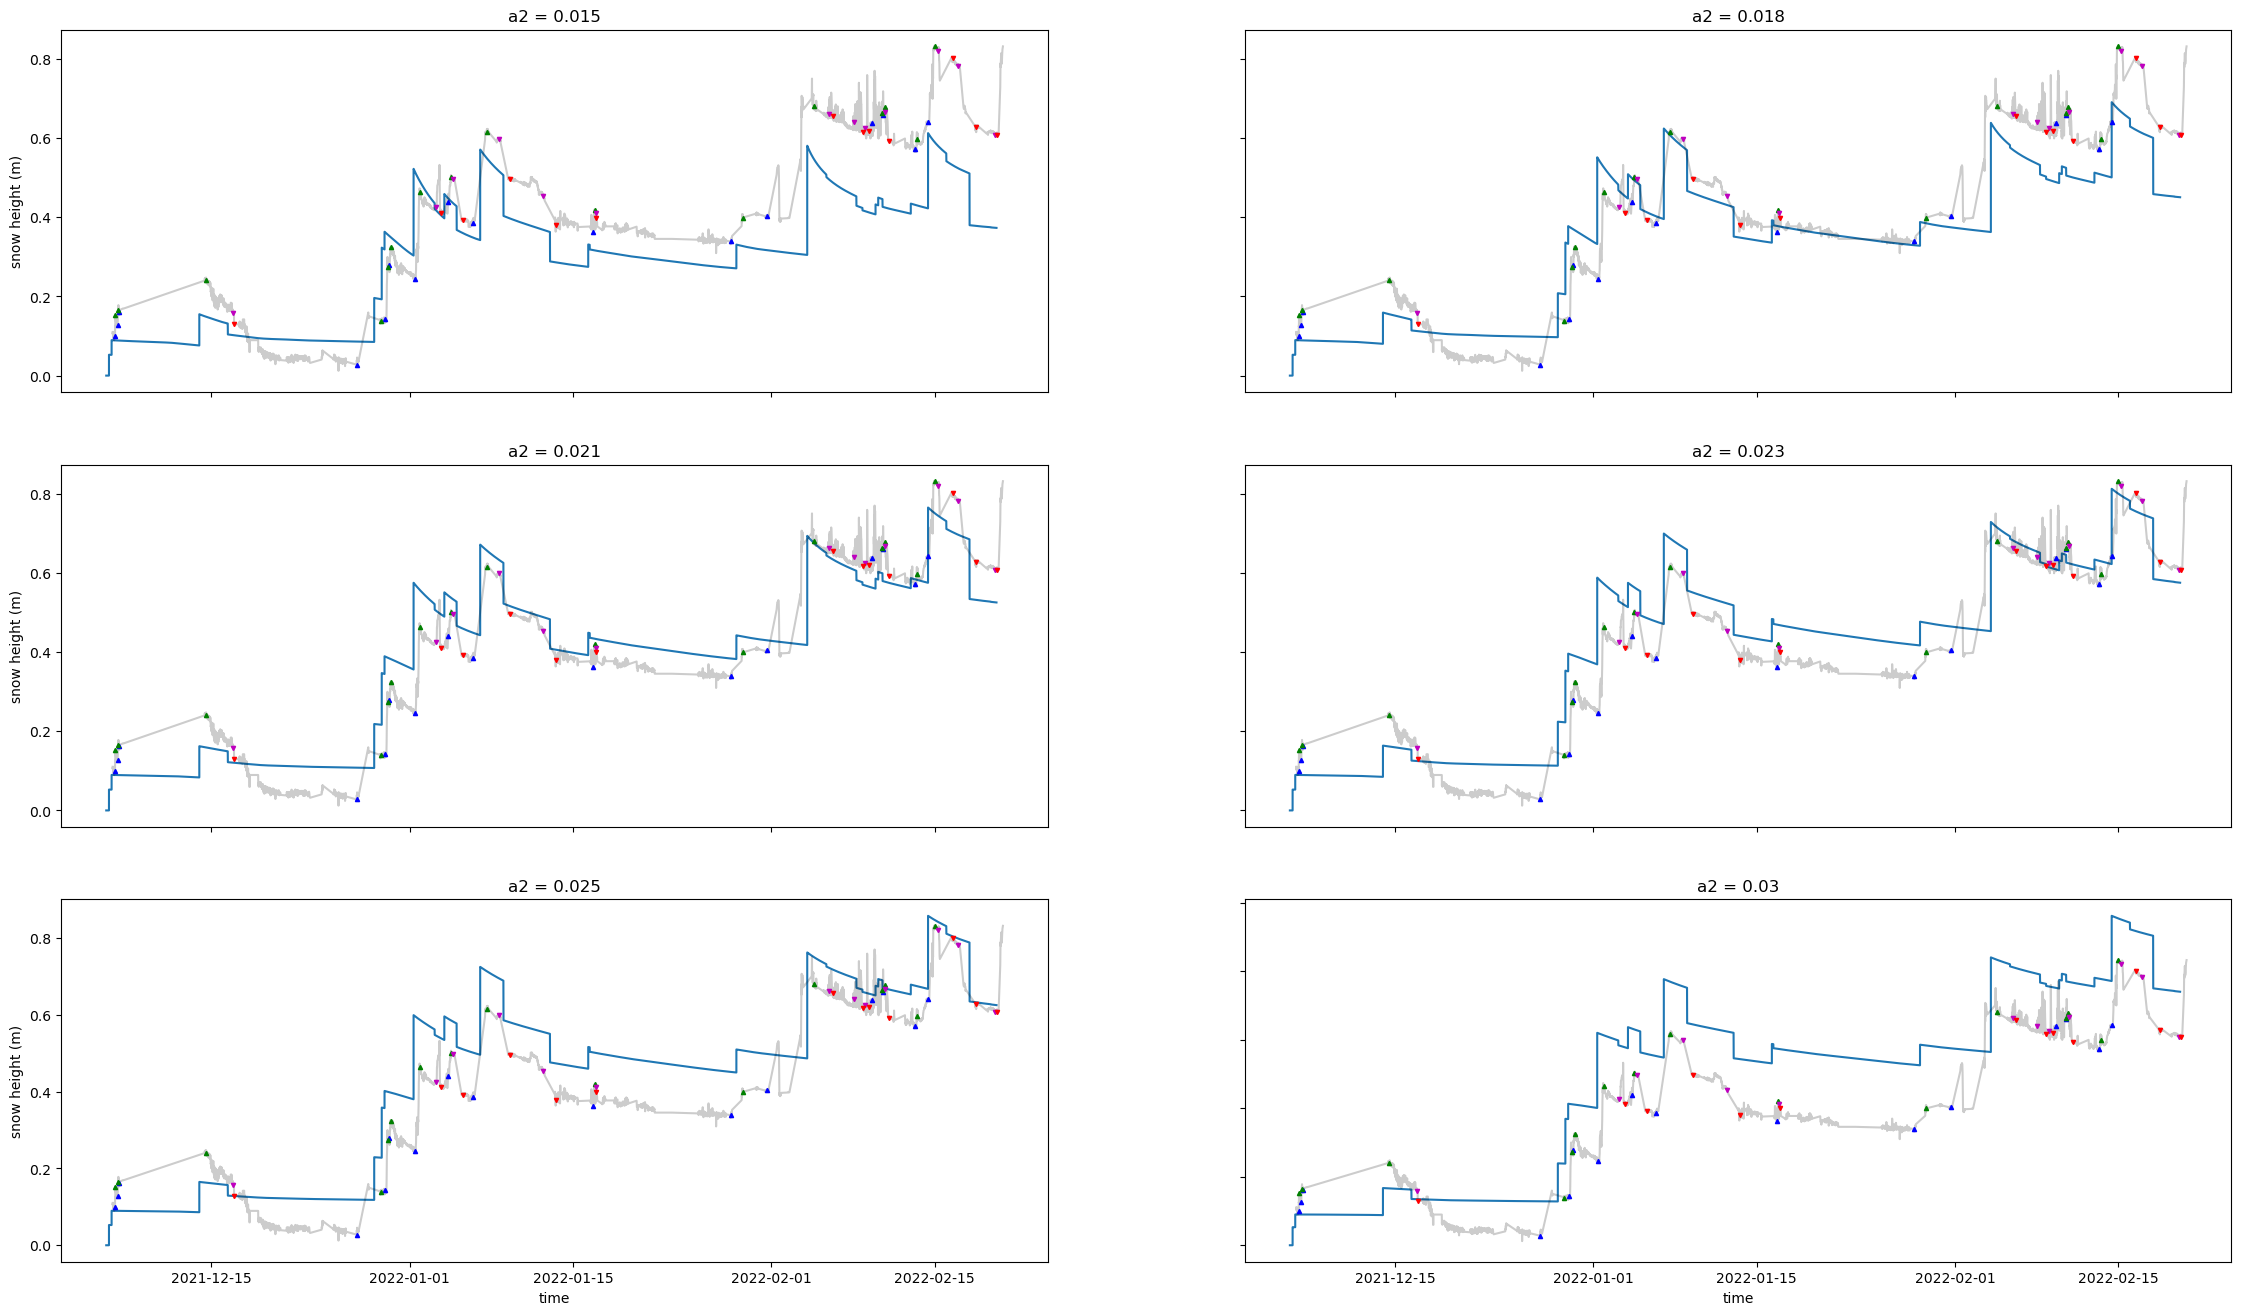

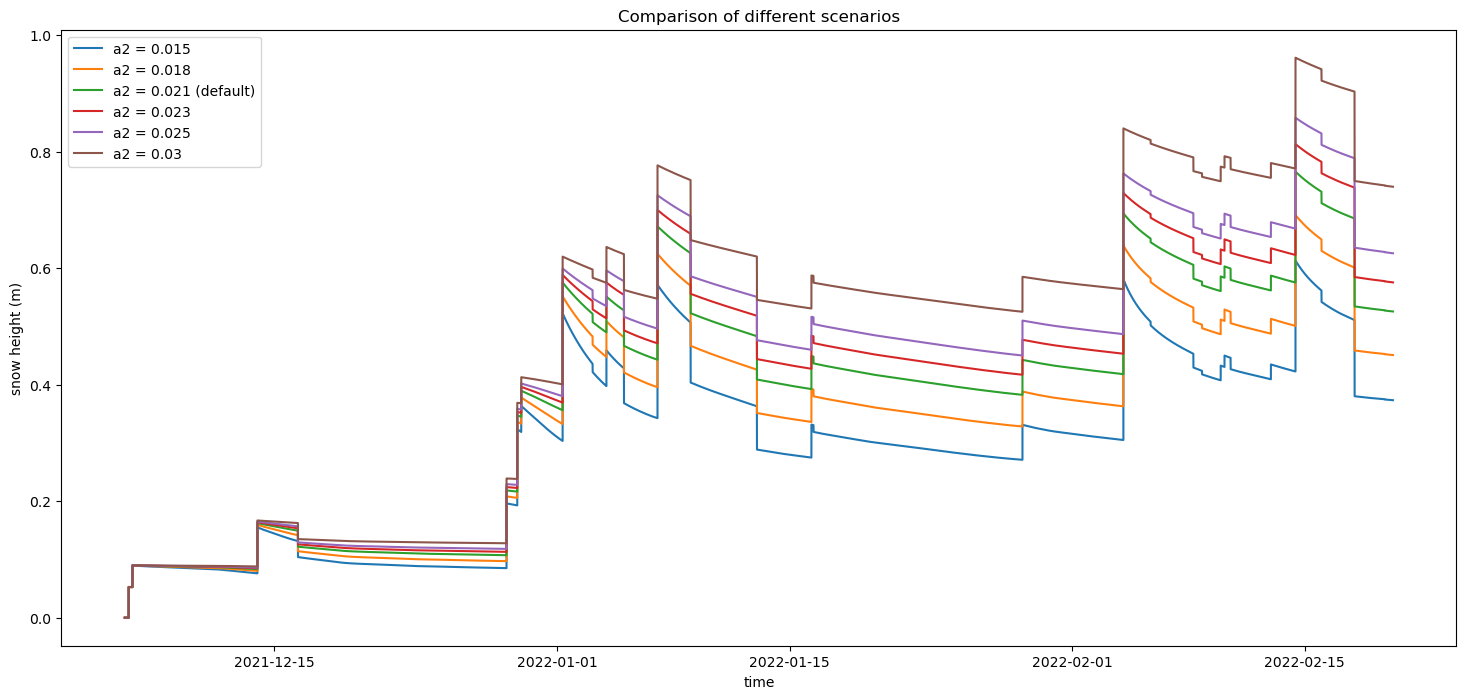

In [18]:
fig, axs = plt.subplots(round(len(range_of_param_variation)/2 + 0.4), 2, figsize=(28, 16))
fig2, axs2 = plt.subplots(1, 1, figsize=(18, 8))

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='snow height (m)')
    ax.label_outer()
    
axs2.set(xlabel='time', ylabel='snow height (m)')
axs2.set_title('Comparison of different scenarios')

for param_index in range(len(range_of_param_variation)):
    
    a2 = range_of_param_variation[param_index]   # TODO update this each time (name of variable), careful if derived parameters depend on it!
    nb_iterations = int(data_duration_in_s/dt + 1)
    
    results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
    start_accumulation, start_erosion, end_accumulation, end_erosion = results[0], results[1], results[2], results[3]

    # Convert end times into more manageable orders of magnitude

    end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
    end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

    end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
    end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

    # Update variables at each timepoint

    snowpack = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp,
                                       met_time_data=met_time, new_snow_ro=simul_new_snow_ro,
                                       fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve)

    ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]
     
    # Define total_snow_depth
    
    simulation_times = pd.date_range(start=data_start_date,freq=str(dt)+'S',periods=nb_iterations)
    total_snow_depth = [sum(depth_evolution[i][j] for j in range(max_nb_of_layers)) for i in range(len(depth_evolution))]
    
    # Plot results to compare
            
    axs[param_index//2, param_index%2].plot(simulation_times, total_snow_depth, label='simulated snow depth')
    axs[param_index//2, param_index%2].set_title(name_of_param+' = '+str(range_of_param_variation[param_index]))
    
    axs[param_index//2, param_index%2].plot(data_set_used.time.values, data_set_used.isel(x=x_sel, y=y_sel).snow_surface, c='k', alpha=0.2)

    axs[param_index//2, param_index%2].plot(data_set_used.time.values[start_accumulation], data_set_used.isel(x=x_sel, y=y_sel, time=start_accumulation).snow_surface, c='b', marker='^', markersize=3, linestyle='None', label='start accum.')
    axs[param_index//2, param_index%2].plot(data_set_used.time.values[end_accumulation], data_set_used.isel(x=x_sel, y=y_sel, time=end_accumulation).snow_surface, c='g', marker='^', markersize=3, linestyle='None', label='end accum.')
    axs[param_index//2, param_index%2].plot(data_set_used.time.values[start_erosion], data_set_used.isel(x=x_sel, y=y_sel, time=start_erosion).snow_surface, c='m', marker='v', markersize=3, linestyle='None', label='start erosion')
    axs[param_index//2, param_index%2].plot(data_set_used.time.values[end_erosion], data_set_used.isel(x=x_sel, y=y_sel, time=end_erosion).snow_surface, c='r', marker='v', markersize=3, linestyle='None', label='end erosion')
    
    # Plot all curves on same plot
    
    if param_index == range_of_param_variation.index(default_value_of_param):
        curve_label = name_of_param + ' = ' + str(range_of_param_variation[param_index]) + ' (default)'
    else:
        curve_label = name_of_param + ' = ' + str(range_of_param_variation[param_index])
        
    axs2.plot(simulation_times, total_snow_depth, label=curve_label)

    result_eval_sq_diff = squared_diff(data_set_used, x_sel, y_sel, dt, nb_iterations, total_snow_depth)    # TODO adapt to chosen metrics
    result_eval_abs_diff = abs_diff(data_set_used, x_sel, y_sel, dt, nb_iterations, total_snow_depth)
    result_eval_max_abs = max_abs_diff(data_set_used, x_sel, y_sel, dt, nb_iterations, total_snow_depth)
    
    result_list_sq.append(result_eval_sq_diff)    # TODO adapt to chosen metrics
    result_list_abs.append(result_eval_abs_diff)
    result_list_max_abs.append(result_eval_max_abs)

axs2.legend()
a2 = default_value_of_param   # TODO update this each time (name of variable)


[Back to top section](#top)

In [19]:
if save_figures:
    fig.savefig(directory_to_save_figs_in + 'graphs_'+name_of_param+'.png')
    fig2.savefig(directory_to_save_figs_in + 'all_curves_'+name_of_param+'.png')

In [20]:
# Save parameters and results in a .txt file

if save_text_results:
    with open(directory_to_save_figs_in + 'sensitivity_tests.txt', 'a') as param_file:
        param_file.write(name_of_param + str(range_of_param_variation) + ' results for squared differences: ' + str(result_list_sq) + ' results for absolute value differences: ' + str(result_list_abs) + ' results for max absolute value difference: ' + str(result_list_max_abs) + '\n \n')
    # TODO adapt to chosen metrics

## Plot results in terms of different metrics

In [ ]:
# TODO adapt all that follows to chosen metrics

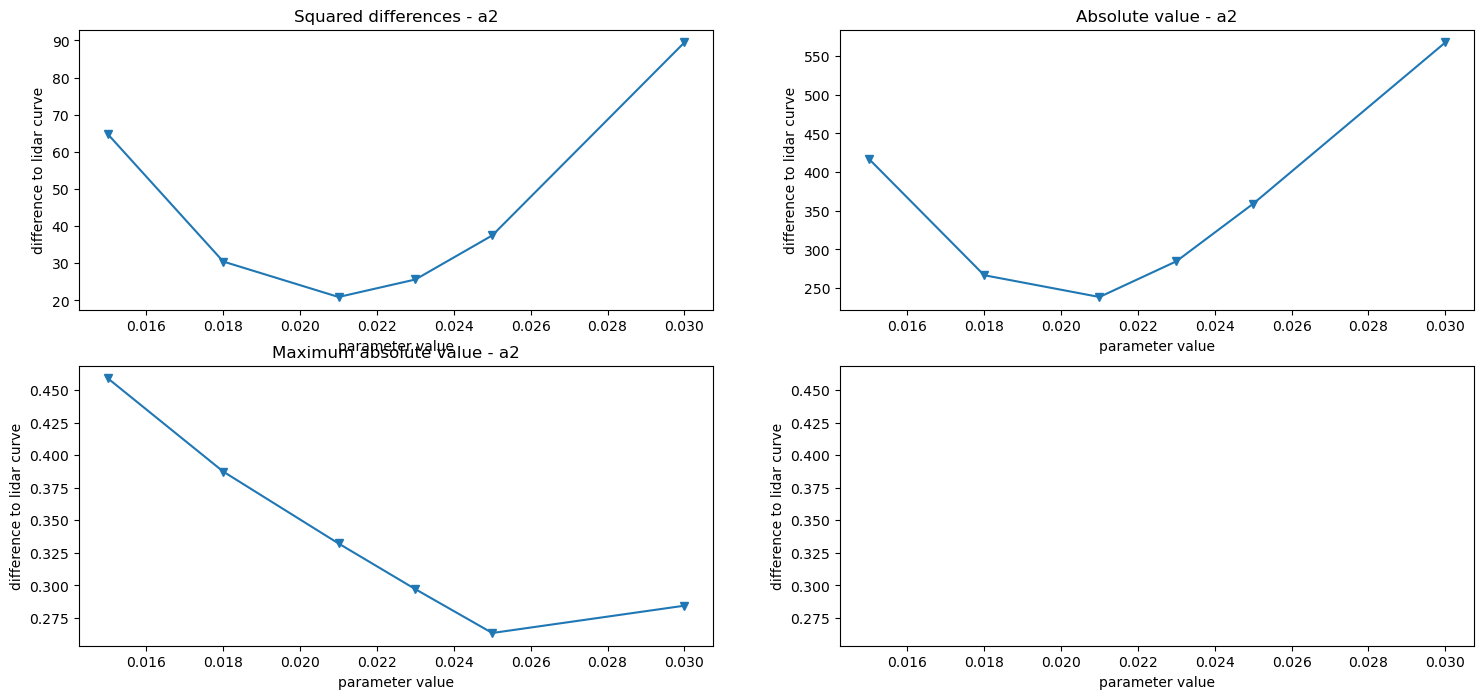

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(18, 8))
axs[0, 0].plot(range_of_param_variation, result_list_sq, marker='v')
axs[0, 0].set_title('Squared differences - ' + name_of_param)

axs[0, 1].plot(range_of_param_variation, result_list_abs, marker='v')
axs[0, 1].set_title('Absolute value - ' + name_of_param)

axs[1, 0].plot(range_of_param_variation, result_list_max_abs, marker='v')
axs[1, 0].set_title('Maximum absolute value - ' + name_of_param)

axs[1, 1].plot(range_of_param_variation, result_list_max_abs, linestyle='None')

for ax in axs.flat:
    ax.set(xlabel='parameter value', ylabel='difference to lidar curve')
    
# TODO add a colored marker for the default value?


In [22]:
if save_figures:
    fig.savefig(directory_to_save_figs_in + 'results_'+name_of_param+'.png')

## Transpose results into percentages for comparatibility

In [23]:
def list_to_percent(param_list, default_value):
    '''
    Function that converts values in a list to the percentage of a default value they represent
    Args:
        param_list: list of values to be converted
        default_value: value that corresponds to 100%
    Returns:
        percent_param_list: array containing the converted values
    '''
    param_list = np.array(param_list)
    percent_param_list = np.divide(param_list, default_value) * 100
    return(percent_param_list)

In [24]:
index_of_default = range_of_param_variation.index(default_value_of_param)

percent_params = list_to_percent(range_of_param_variation, default_value_of_param)
percent_results_sq = list_to_percent(result_list_sq, result_list_sq[index_of_default])
percent_results_abs = list_to_percent(result_list_abs, result_list_abs[index_of_default])
percent_results_max_abs = list_to_percent(result_list_max_abs, result_list_max_abs[index_of_default])

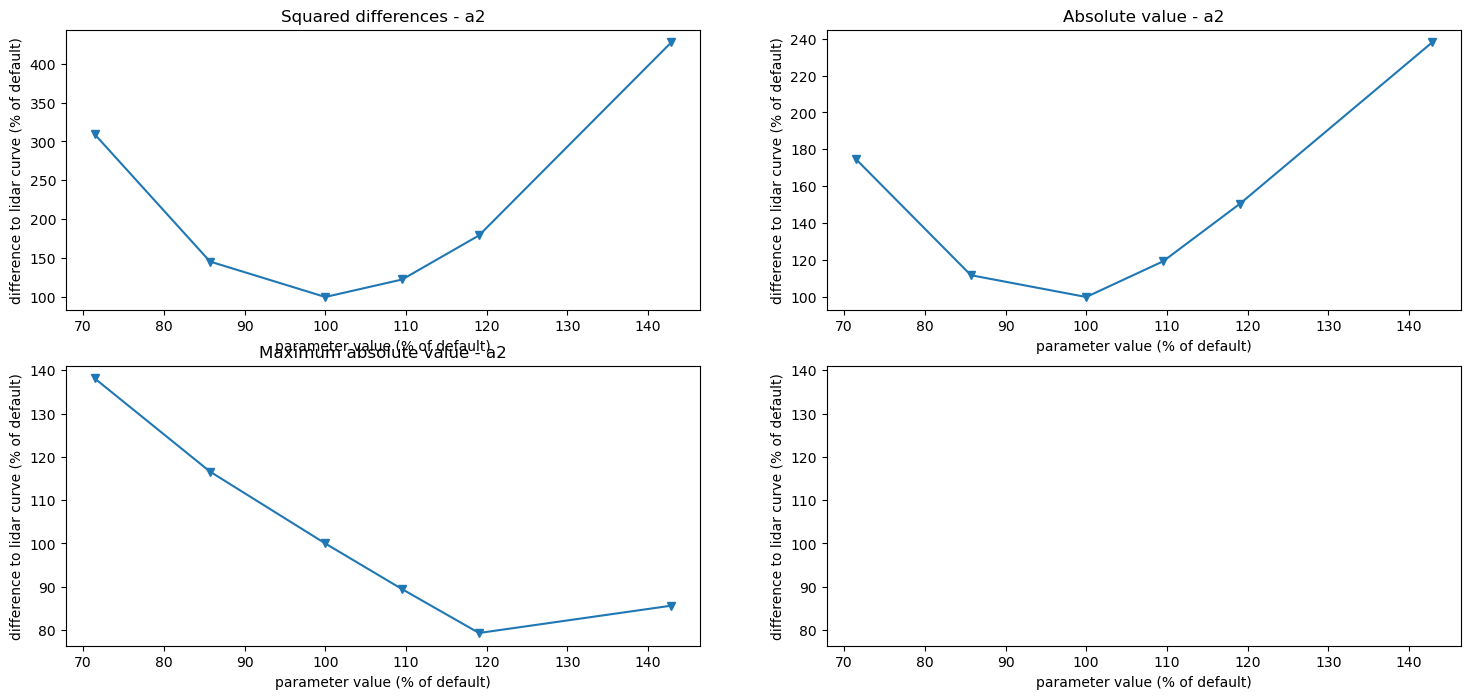

In [25]:
#from matplotlib import rc    # TODO
#rc('text', usetex=True)
# rc('font', size=14)
# rc('legend', fontsize=13)
#rc('text.latex', preamble=r'\usepackage{cmbright}')

#import matplotlib
#matplotlib.rcParams['text.usetex'] = True

fig, axs = plt.subplots(2, 2, figsize=(18, 8))
axs[0, 0].plot(percent_params, percent_results_sq, marker='v')
axs[0, 0].set_title('Squared differences - ' + name_of_param)

axs[0, 1].plot(percent_params, percent_results_abs, marker='v')
axs[0, 1].set_title('Absolute value - ' + name_of_param)

axs[1, 0].plot(percent_params, percent_results_max_abs, marker='v')
axs[1, 0].set_title('Maximum absolute value - ' + name_of_param)

axs[1, 1].plot(percent_params, percent_results_max_abs, linestyle='None')

for ax in axs.flat:
    ax.set(xlabel='parameter value (% of default)', ylabel='difference to lidar curve (% of default)')


In [26]:
if save_figures:
    fig.savefig(directory_to_save_figs_in + 'results_percent_'+name_of_param+'.png')

In [27]:
grad_sq = np.gradient(percent_results_sq, percent_params)
grad_abs = np.gradient(percent_results_abs, percent_params)
grad_max_abs = np.gradient(percent_results_max_abs, percent_params)

In [28]:
# Save percentages and gradients in a .txt file

if save_text_results:
    with open(directory_to_save_figs_in + 'sensitivity_tests.txt', 'a') as param_file:
        param_file.write(name_of_param + ' ALL VALUES IN % OF DEFAULT: ' + str(percent_params) + ' results for squared differences: ' + str(percent_results_sq) + ' results for absolute value differences: ' + str(percent_results_abs) + ' results for max absolute value difference: ' + str(percent_results_max_abs) + '\n')
        param_file.write(name_of_param + ' gradients of results at each point (partial derivative with respect to parameter, computed on the % curves): ' + ' for squared differences: ' + str(grad_sq) + ' for absolute value differences: ' + str(grad_abs) + ' for max absolute value difference: ' + str(grad_max_abs) + '\n \n')


[Back to top section](#top)